In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
df = pd.read_csv('DF_FINAL.csv')
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])
df

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id
0,A,a,AC,TP 0.2,2023-01-06,1.000000,0.010000,A_a_AC_TP 0.2
1,A,a,AC,TP 0.2,2023-01-13,1.000000,4.010000,A_a_AC_TP 0.2
2,A,a,AC,TP 0.2,2023-01-20,61.000000,6.010000,A_a_AC_TP 0.2
3,A,a,AC,TP 0.2,2023-01-27,0.000000,8.010000,A_a_AC_TP 0.2
4,A,a,AC,TP 0.2,2023-02-03,18.879000,9.520000,A_a_AC_TP 0.2
...,...,...,...,...,...,...,...,...
58305,I,an,AD,PET 1.0,2024-11-29,54.766687,78.192999,I_an_AD_PET 1.0
58306,I,an,AD,PET 1.0,2024-12-06,65.133425,171.193998,I_an_AD_PET 1.0
58307,I,an,AD,PET 1.0,2024-12-13,59.458602,46.503001,I_an_AD_PET 1.0
58308,I,an,AD,PET 1.0,2024-12-20,77.697035,8.463000,I_an_AD_PET 1.0


In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
# --- Метрики ---
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.where(denom == 0, 1, denom)) * 100

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

In [5]:
# Подгонка одной модели
def evaluate_sarima(y_train, y_val, order, seasonal):
    try:
        model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=(seasonal[0], seasonal[1], seasonal[2], seasonal[3]),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        pred_val = results.forecast(steps=len(y_val))
        mae = mean_absolute_error(y_val, pred_val)
        return (mae, order, seasonal, results)
    except:
        return (np.inf, order, seasonal, None)

In [6]:
# Основная функция
def fit_sarima_for_row(df, row_id):
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)

    y = ts['fact']
    n = len(y)
    train_end = int(n * 0.9)
    val_end = int(n * 0.95)

    y_train = y.iloc[:train_end]
    y_val = y.iloc[train_end:val_end]
    y_test = y.iloc[val_end:]

    results = Parallel(n_jobs=-1)(
        delayed(evaluate_sarima)(y_train, y_val, order, seasonal)
        for order in pdq for seasonal in seasonal_pdq
    )

    best_result = min(results, key=lambda x: x[0])
    best_mae, best_order, best_seasonal_order, _ = best_result

    # Финальная модель на train + val
    model_final = SARIMAX(
        y.iloc[:val_end],
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_final = model_final.fit(disp=False)
    forecast = results_final.forecast(steps=len(y_test))
    forecast = np.clip(forecast, 0, None)

    # Метрики
    mae_test = mean_absolute_error(y_test, forecast)
    wape_test = wape(y_test.values, forecast.values)
    smape_test = smape(y_test.values, forecast.values)

    return {
        'row_id': row_id,
        'best_order': best_order,
        'best_seasonal_order': best_seasonal_order,
        'mae': mae_test,
        'wape': wape_test,
        'smape': smape_test,
        'actual': y_test,
        'forecast': forecast
    }

In [7]:
def fit_sarima_for_row(df, row_id):
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)

    y = ts['fact']
    n = len(y)
    train_end = int(n * 0.9)
    val_end = int(n * 0.95)

    y_train = y.iloc[:train_end]
    y_val = y.iloc[train_end:val_end]
    y_test = y.iloc[val_end:]

    best_mae = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for order in pdq:
        for seasonal in seasonal_pdq:
            try:
                model = SARIMAX(
                    y_train,
                    order=order,
                    seasonal_order=(seasonal[0], seasonal[1], seasonal[2], seasonal[3]),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                pred_val = results.forecast(steps=len(y_val))
                mae = mean_absolute_error(y_val, pred_val)

                if mae < best_mae:
                    best_mae = mae
                    best_order = order
                    best_seasonal_order = seasonal
                    best_model = results

            except:
                continue

    if best_model is None:
        return None

    model_final = SARIMAX(
        y.iloc[:val_end],
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_final = model_final.fit(disp=False)
    forecast = results_final.forecast(steps=len(y_test))
    forecast = np.clip(forecast, 0, None)

    return {
        'row_id': row_id,
        'best_order': best_order,
        'best_seasonal_order': best_seasonal_order,
        'mae': mean_absolute_error(y_test, forecast),
        'wape': wape(y_test.values, forecast.values),
        'smape': smape(y_test.values, forecast.values),
        'actual': y_test,
        'forecast': forecast
    }

In [8]:
p = q = range(0, 2)             
P = Q = range(0, 2)             
d = [0,1]
D = [0,1]
s_values = [12]                 

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s_values))

In [9]:
result = fit_sarima_for_row(df, 'A_a_AD_PET 1.0')
print(result)

F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No 

{'row_id': 'A_a_AD_PET 1.0', 'best_order': (0, 0, 1), 'best_seasonal_order': (1, 1, 1, 12), 'mae': 49.20641038756357, 'wape': np.float64(54.352906032734474), 'smape': np.float64(94.16896808869696), 'actual': Week_End_Date
2024-11-22     73.974998
2024-11-29    103.561001
2024-12-06      0.010000
2024-12-13    169.080002
2024-12-20    164.851998
2024-12-27     31.710000
Name: fact, dtype: float64, 'forecast': 2024-11-22    101.111858
2024-11-29     84.084856
2024-12-06     67.189678
2024-12-13     92.972516
2024-12-20     91.026478
2024-12-27      0.197226
Freq: W-FRI, Name: predicted_mean, dtype: float64}


F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
def plot_forecast_full_history(df, result_dict):
    row_id = result_dict['row_id']
    best_order = result_dict['best_order']
    best_seasonal_order = result_dict['best_seasonal_order']
    smape_score = result_dict['smape']
    
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)
    
    full_y = ts['fact']
    forecast = result_dict['forecast']
    actual = result_dict['actual']
    
    # Построение
    plt.figure(figsize=(14, 6))
    plt.plot(full_y.index, full_y.values, label='Actual', marker='o')
    plt.plot(actual.index, forecast.values, label='Forecast', marker='x', linestyle='--')
    
    title = (
        f"{row_id} | SMAPE: {smape_score:.2f}%\n"
        f"Best SARIMA{best_order} x {best_seasonal_order}"
    )
    plt.title(title)
    plt.xlabel("Week_End_Date")
    plt.ylabel("fact")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

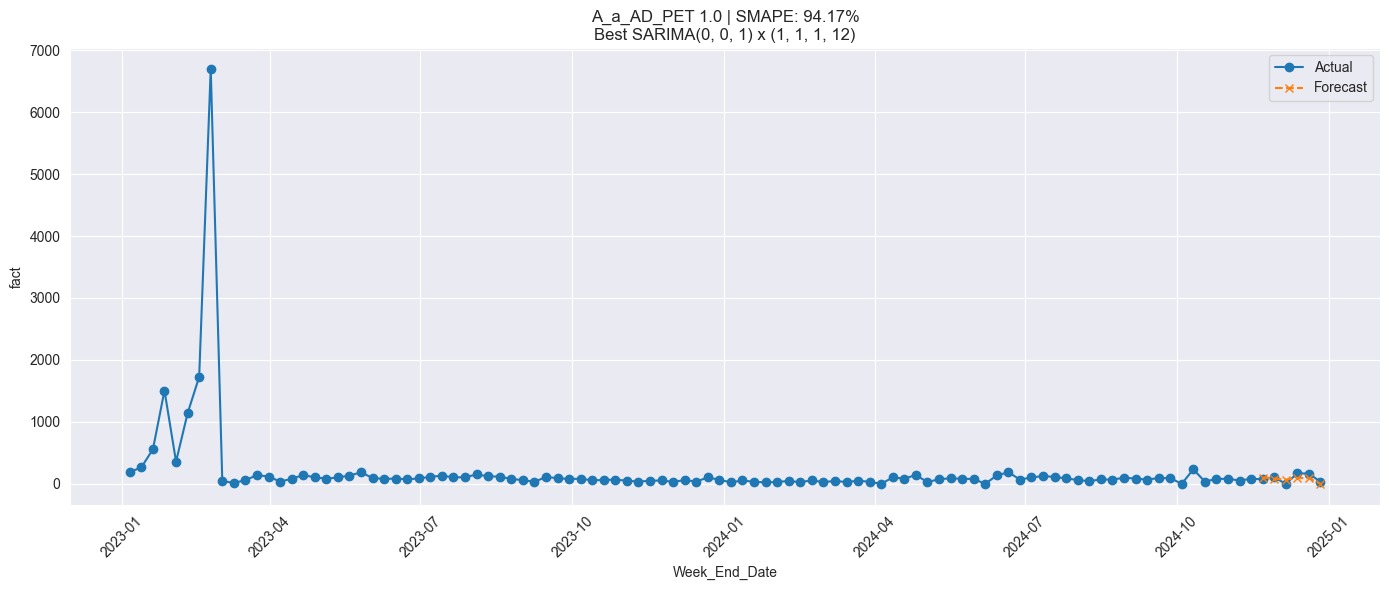

In [11]:
plot_forecast_full_history(df, result)

Для всего датасета

In [12]:
def fit_all_series(df):
    results = []
    unique_ids = df['row_id'].unique()

    for row_id in tqdm(unique_ids, desc="Обработка рядов"):
        try:
            result = fit_sarima_for_row(df, row_id)
            results.append(result)
        except Exception as e:
            print(f"Ошибка на {row_id}: {e}")
            continue

    return results

In [13]:
def fit_all_series_parallel(df, n_jobs=-1):
    unique_ids = df['row_id'].unique()

    results = Parallel(n_jobs=n_jobs)(
        delayed(fit_sarima_for_row)(df, row_id) for row_id in tqdm(unique_ids, desc="Обработка рядов")
    )

    return [r for r in results if r is not None]

In [14]:
all_results = fit_all_series_parallel(df, n_jobs=-1)

Обработка рядов: 100%|██████████| 602/602 [08:07<00:00,  1.24it/s]


In [15]:
metrics_df = pd.DataFrame([{
    'row_id': r['row_id'],
    'mae': r['mae'],
    'wape': r['wape'],
    'smape': r['smape'],
    'order': r['best_order'],
    'seasonal_order': r['best_seasonal_order']
} for r in all_results])
metrics_df

,row_id,mae,wape,smape,order,seasonal_order
0,A_a_AC_TP 0.2,1.453920,65.227471,123.147706,"(0, 0, 1)","(0, 0, 1, 12)"
1,A_a_AC_TP 1.0,87.358193,99.999649,199.750490,"(1, 0, 0)","(0, 0, 0, 12)"
2,A_a_AD_PET 1.0,49.206410,54.352906,94.168968,"(0, 0, 1)","(1, 1, 1, 12)"
3,A_b_AA_PET 0.5,82.096058,136.275602,153.837925,"(1, 1, 0)","(1, 1, 1, 12)"
4,A_b_AA_PET 1.0,32.209383,157.585294,164.790368,"(1, 0, 0)","(1, 0, 0, 12)"
...,...,...,...,...,...,...
597,I_am_AH_PET 1.0,179.625707,99.997704,147.358455,"(1, 0, 0)","(0, 0, 0, 12)"
598,I_am_AJ_PET 1.0,75.543750,85.619689,137.346382,"(0, 1, 0)","(0, 0, 0, 12)"
599,I_an_AC_PET 0.3,6.511544,109.856207,186.109558,"(1, 0, 1)","(0, 0, 0, 12)"
600,I_an_AC_TP 2.0,177.242513,99.048137,163.770195,"(1, 0, 0)","(1, 0, 0, 12)"


In [16]:
metrics_df[['wape', 'smape']].describe()

,wape,smape
count,602.000000,602.000000
mean,401.987388,105.398376
std,3393.171140,49.467865
min,9.756035,5.398014
25%,66.932090,66.663823
50%,96.685685,98.649359
75%,107.322078,139.632812
max,64014.839591,200.000000


In [29]:
metrics_df['WAPE_clipped'] = metrics_df['wape'].clip(upper=300)
metrics_df[['wape', 'smape', 'WAPE_clipped']].describe()

,wape,smape,WAPE_clipped
count,602.000000,602.000000,602.000000
mean,401.987388,105.398376,102.741376
std,3393.171140,49.467865,60.576120
min,9.756035,5.398014,9.756035
25%,66.932090,66.663823,66.932090
50%,96.685685,98.649359,96.685685
75%,107.322078,139.632812,107.322078
max,64014.839591,200.000000,300.000000


In [25]:
def plot_fact_vs_forecast_full(df, all_results, target_row_ids):
    for row_id in target_row_ids:
        row_data = next((r for r in all_results if r['row_id'] == row_id), None)
        if row_data is None:
            print(f"⚠️ Прогноз для {row_id} не найден.")
            continue

        # Исторические значения
        y_full = df[df['row_id'] == row_id].sort_values('Week_End_Date')
        y_full.set_index('Week_End_Date', inplace=True)

        # Объединяем actual и forecast
        y_actual = row_data['actual']
        y_forecast = row_data['forecast']

        plt.figure(figsize=(12, 4))
        plt.plot(y_full.index, y_full['fact'], label='Actual', marker='o', alpha=0.6)
        plt.plot(y_forecast.index, y_forecast.values, label='Forecast', marker='x', linestyle='--')
        plt.title(f"{row_id} | SMAPE: {row_data['smape']:.2f}%")
        plt.xlabel("Week_End_Date")
        plt.ylabel("fact")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

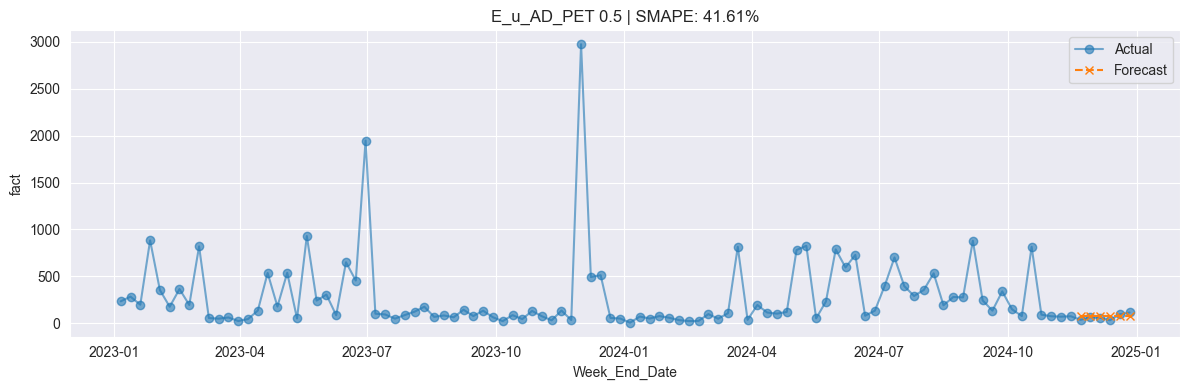

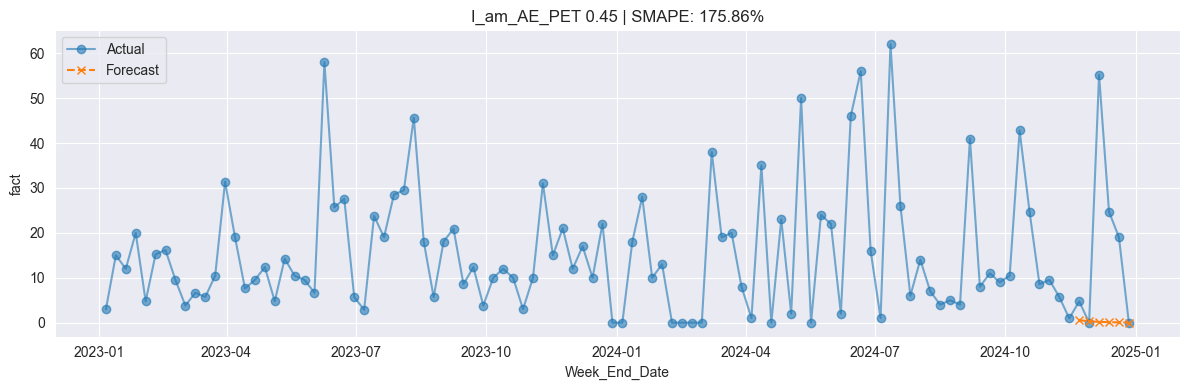

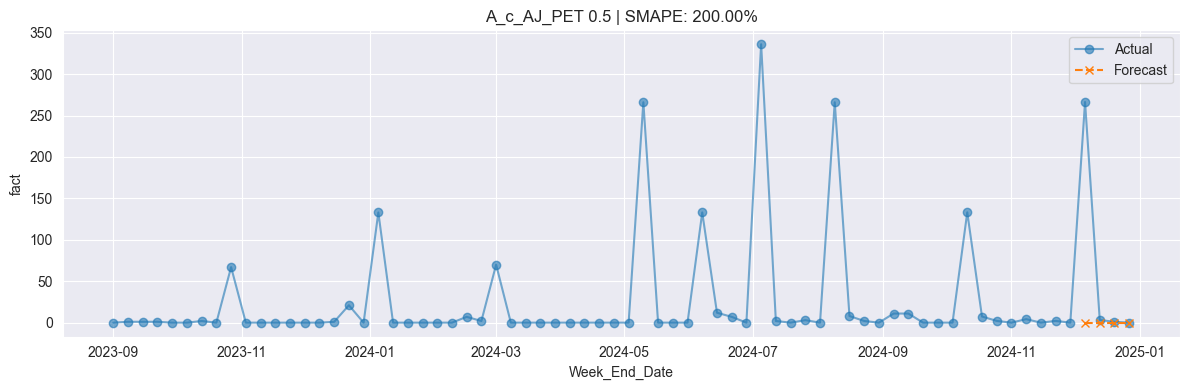

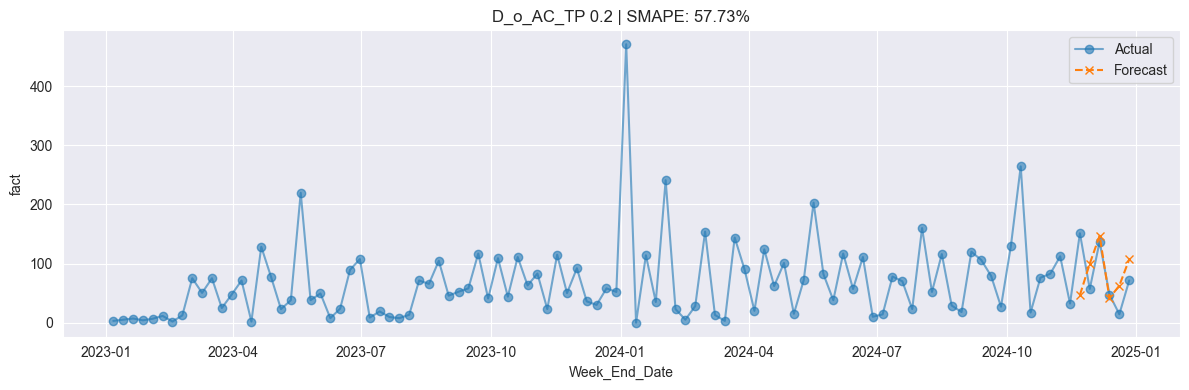

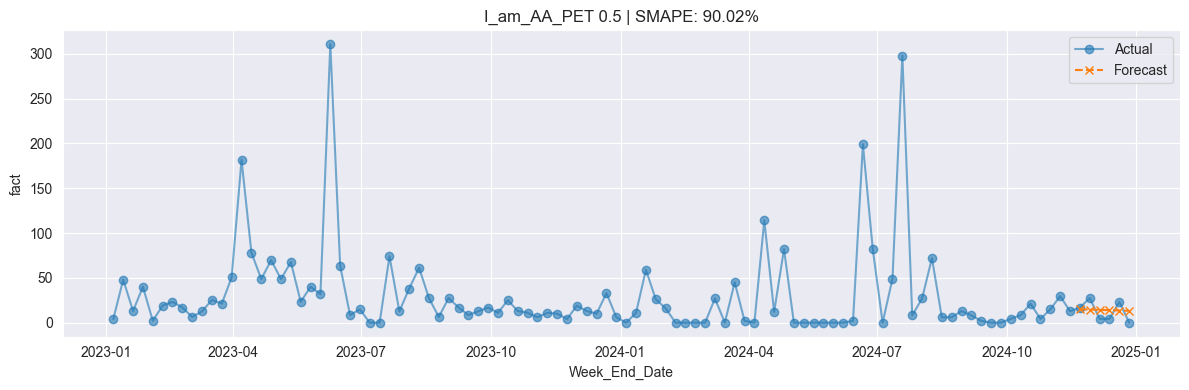

In [26]:
target_ids = [
  'E_u_AD_PET 0.5',
  'I_am_AE_PET 0.45',
  'A_c_AJ_PET 0.5',
  'D_o_AC_TP 0.2',
  'I_am_AA_PET 0.5'
]

plot_fact_vs_forecast_full(df, all_results, target_ids)

In [27]:
# Фильтруем и собираем метрики
metrics_summary = []

for row_id in target_ids:
    r = next((x for x in all_results if x['row_id'] == row_id), None)
    if r:
        metrics_summary.append({
            'row_id': row_id,
            'mae': round(r.get('mae', float('nan')), 2),
            'wape': round(r.get('wape', float('nan')), 2),
            'smape': round(r.get('smape', float('nan')), 2),
        })
    else:
        metrics_summary.append({
            'row_id': row_id,
            'mae': 'N/A',
            'wape': 'N/A',
            'smape': 'N/A',
        })

# Создаём DataFrame
metrics_df_subset = pd.DataFrame(metrics_summary)
metrics_df_subset

,row_id,mae,wape,smape
0,E_u_AD_PET 0.5,28.18,41.23,41.61
1,I_am_AE_PET 0.45,17.19,99.43,175.86
2,A_c_AJ_PET 0.5,67.64,100.00,200.00
3,D_o_AC_TP 0.2,41.24,51.72,57.73
4,I_am_AA_PET 0.5,9.56,75.33,90.02


In [21]:
from statsmodels.tsa.stattools import acf
from collections import Counter
from statsmodels.tsa.seasonal import STL

In [18]:
def estimate_s_from_acf(y, max_lag=60, threshold=0.3):
    try:
        acf_vals = acf(y, nlags=max_lag, fft=True)
        # Игнорируем лаг 0
        lags = np.arange(1, len(acf_vals))
        # Выбираем лаги с автокорреляцией выше порога
        strong_lags = lags[acf_vals[1:] > threshold]
        return int(strong_lags[0]) if len(strong_lags) > 0 else None
    except:
        return None

In [19]:
# --- Основной цикл по всем рядам ---
s_guesses = []

for row_id in tqdm(df['row_id'].unique(), desc="Анализ сезонности (ACF)"):
    y = df[df['row_id'] == row_id].sort_values('Week_End_Date')['fact']
    if len(y) < 30:
        continue  # слишком короткие ряды пропускаем
    s = estimate_s_from_acf(y)
    if s is not None:
        s_guesses.append(s)

# --- Анализ частоты ---
counter = Counter(s_guesses)
print("\n Топ популярных сезонных лагов:")
for s_val, count in counter.most_common(10):
    print(f"s = {s_val}: {count} рядов")

Анализ сезонности (ACF): 100%|██████████| 602/602 [00:02<00:00, 288.22it/s]


🎯 Топ популярных сезонных лагов:
s = 1: 99 рядов
s = 4: 15 рядов
s = 2: 11 рядов
s = 13: 7 рядов
s = 6: 7 рядов
s = 22: 6 рядов
s = 9: 4 рядов
s = 3: 4 рядов
s = 18: 3 рядов
s = 16: 3 рядов


In [20]:
# Топ-3 лучших по smape (низкий SMAPE)
best_ids = metrics_df.nsmallest(3, 'smape')['row_id'].tolist()

# Топ-3 худших по smape (высокий SMAPE)
worst_ids = metrics_df.nlargest(3, 'smape')['row_id'].tolist()

# 2 случайных
random_ids = metrics_df.sample(2, random_state=42)['row_id'].tolist()

# Итоговая выборка
selected_ids = best_ids + worst_ids + random_ids
print("Выбранные ряды для STL:", selected_ids)

Выбранные ряды для STL: ['C_ao_AJ_PET 1.0', 'G_ae_AD_PET 0.3', 'B_k_AH_PET 1.0', 'A_c_AA_PET 1.0', 'A_c_AJ_PET 0.5', 'A_c_AJ_PET 1.0', 'B_h_AD_CAN 0.33', 'G_aa_AJ_PET 0.5']


In [22]:
def plot_stl_decomposition(df, row_id, s):
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)
    
    y = ts['fact']
    if len(y) < s * 2:
        print(f"❌ Ряд {row_id} слишком короткий для STL с period={s}")
        return

    stl = STL(y, period=s, robust=True)
    result = stl.fit()

    # Визуализация
    result.plot()
    plt.suptitle(f"STL-декомпозиция: row_id = {row_id}, period = {s}", fontsize=14)
    plt.tight_layout()
    plt.show()


🔍 STL-декомпозиция для: C_ao_AJ_PET 1.0


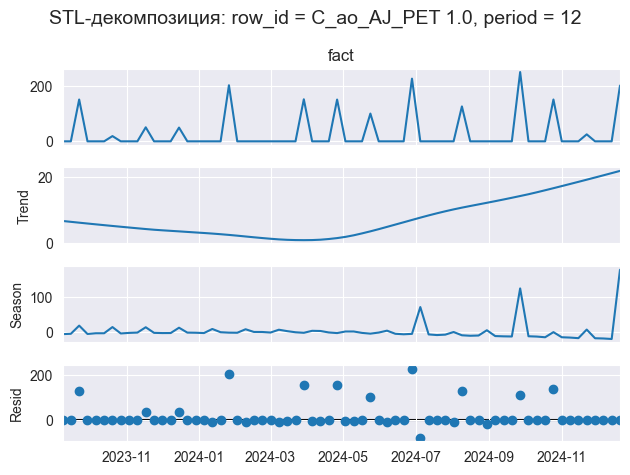


🔍 STL-декомпозиция для: G_ae_AD_PET 0.3


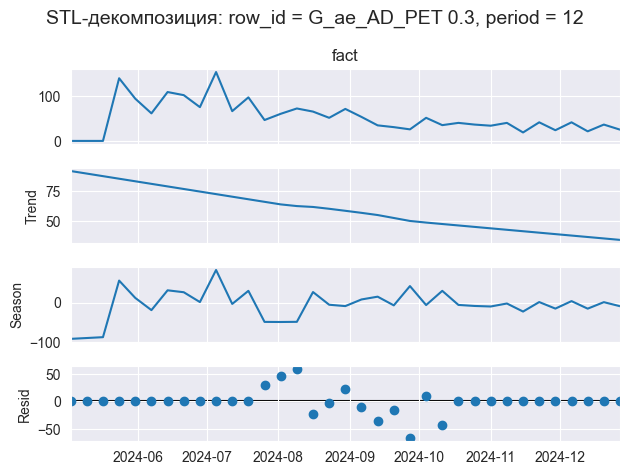


🔍 STL-декомпозиция для: B_k_AH_PET 1.0


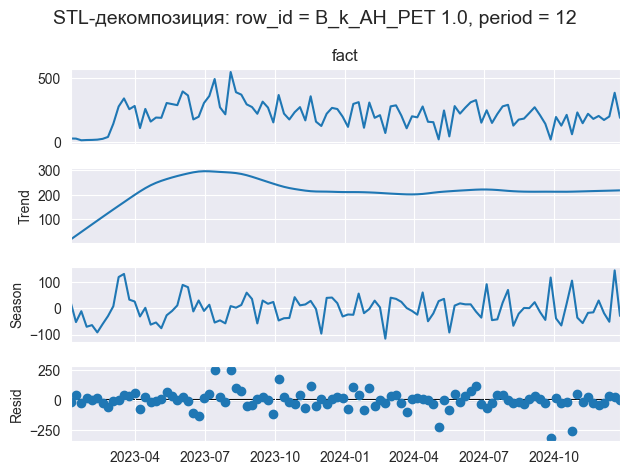


🔍 STL-декомпозиция для: A_c_AA_PET 1.0


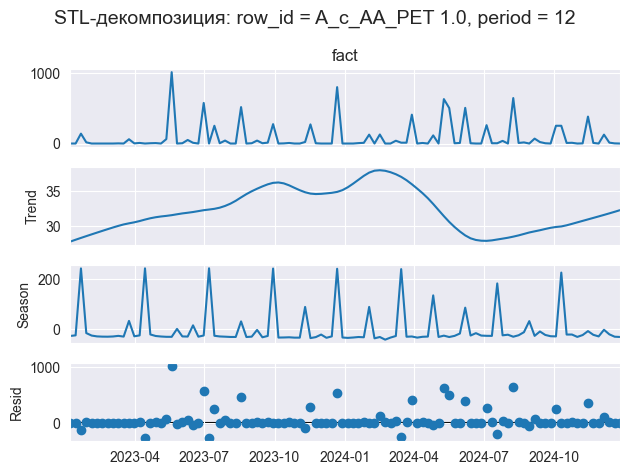


🔍 STL-декомпозиция для: A_c_AJ_PET 0.5


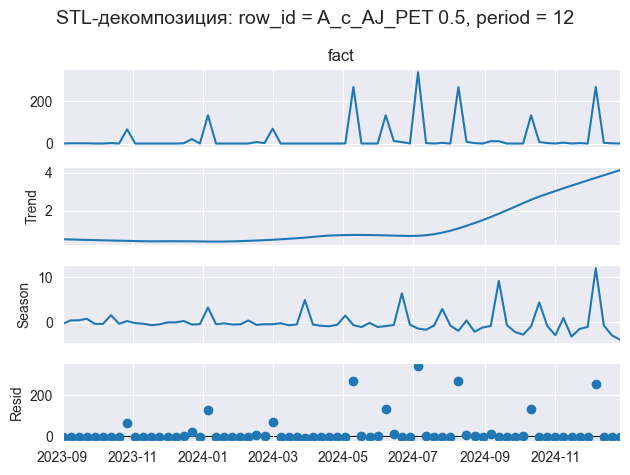


🔍 STL-декомпозиция для: A_c_AJ_PET 1.0


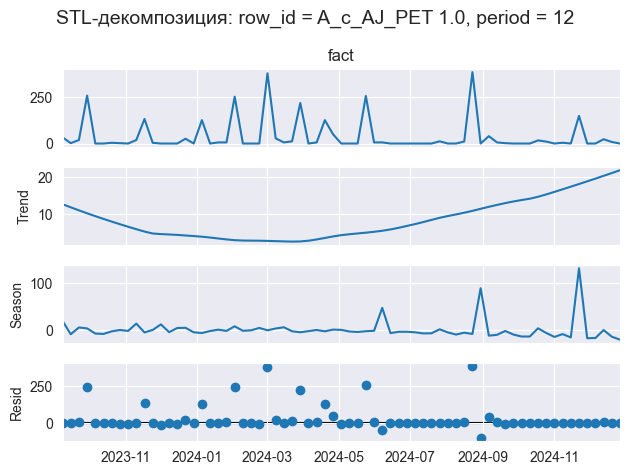


🔍 STL-декомпозиция для: B_h_AD_CAN 0.33


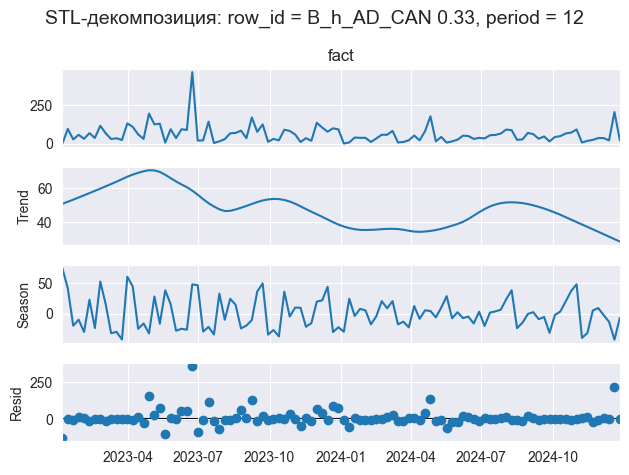


🔍 STL-декомпозиция для: G_aa_AJ_PET 0.5


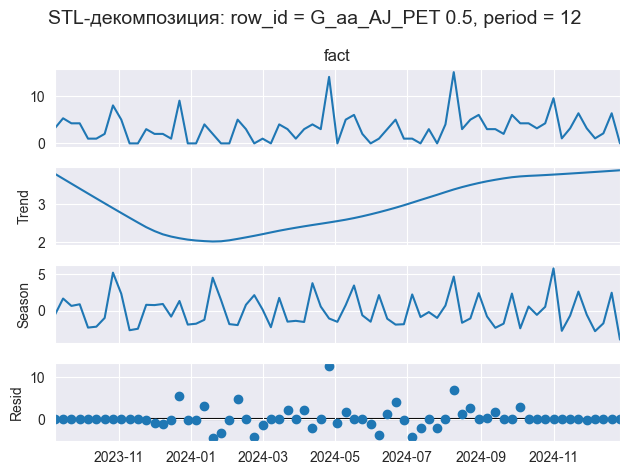

In [24]:
for row in selected_ids:
    print(f"\n🔍 STL-декомпозиция для: {row}")
    plot_stl_decomposition(df, row_id=row, s=12)